TODOs
- [x] begin: text infos
- [x] end: eval, ignoring log_*_interval
- [x] begin: hparams
- [ ] adapt to use in imitation
- [x] option to dump in sync with logging
- [x] begin: graph
- [ ] network (just use eval callback or CheckpointCallback)

In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import numpy as np
from navground import core, sim
from navground_learning.scenarios.corridor_with_obstacle import CorridorWithObstacle

In [14]:
# import datasets.utils
# import tqdm.autonotebook
# import imitation.algorithms.bc

# datasets.utils.tqdm = tqdm.autonotebook.tqdm
# imitation.algorithms.bc.tqdm = tqdm.autonotebook
# datasets.utils.disable_progress_bar()

In [15]:
import numpy as np
import gymnasium as gym
from navground import core, sim
from navground_learning.scenarios.corridor_with_obstacle import CorridorWithObstacle
from navground_learning.utils import GymAgentConfig
from navground_learning.env import SocialReward

scenario = sim.load_scenario("""
type: CorridorWithObstacle
length: 1.0
width: 1.0
min_radius: 0.2
max_radius: 0.2
groups:
  -
    type: thymio
    number: 1
    radius: 0.08
    control_period: 0.05
    color: gold
    kinematics:
      type: 2WDiff
      wheel_axis: 0.094
      max_speed: 0.12
    behavior:
      type: HL
      optimal_speed: 0.12
      horizon: 10
      tau: 0.25
      eta: 0.5
      safety_margin: 0.05
      barrier_angle: 1.0
    state_estimation:
      type: Bounded
      range: 1.0
      update_static_obstacles: true
""")

sensor = sim.load_state_estimation("""
type: Combination
sensors:
  - type: Boundary
    min_y: 0
    max_y: 1
    range: 1
  - type: Discs
    number: 1
    range: 1
    max_speed: 0.0
    max_radius: 0.0
    include_valid: false
""")


duration = 40.0
time_step = 0.1

config = GymAgentConfig(include_target_distance=False, include_velocity=True,
                        include_angular_speed=True, max_acceleration=1.0, 
                        max_angular_acceleration=10.0, use_acceleration_action=True,
                        flat=True)

# we do not penalize small safety_margin violations
env = gym.make('navground', 
    scenario=scenario,
    sensor=sensor,
    config=config,
    time_step=time_step,
    max_duration=duration,
    reward=SocialReward(safety_margin=0.04))


We define a functions to plot and display runs when the agents follow a ML policy

## Reinforcement learning with SAC

In [16]:
from stable_baselines3 import SAC
from stable_baselines3.common.logger import configure


logs = "logs/test_log/SAC13"
model = SAC("MlpPolicy", env, policy_kwargs={'net_arch': [128, 128]}) #, train_freq=(10, "step"))
model.set_logger(configure(logs, ["csv", "tensorboard"]))

In [17]:
# model.policy.predict?? 

In [18]:
from stable_baselines3.common.callbacks import CheckpointCallback, CallbackList

In [19]:
from navground_learning.logging import log_env, log_yaml, LogTrajectoriesCallback, TrajectoryPlotConfig, get_tb_logger, VideoConfig
import torch as th


tc = TrajectoryPlotConfig(enabled=True, number=4, columns=4, color='blue', step=30, width=10)
vc = VideoConfig(enabled=False, fps=30, factor=10) 
cb = LogTrajectoriesCallback(trajectory_plot_config=tc, log_step_interval=1_000, video_config=vc, episodes=10,
                             hparams={'net_arch':  th.Tensor(model.policy_kwargs['net_arch']),
                                      'net_size':  model.policy_kwargs['net_arch'][0]}, 
                             data={"policy_kwargs": model.policy_kwargs}, log_graph=True)

In [20]:
# writer = get_tb_logger(model.logger).writer
# log_env(writer, model.get_env().envs[0].unwrapped)
# log_yaml(writer, "policy_kwargs", model.policy_kwargs)

Training took  19 seconds


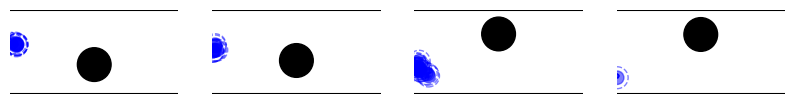

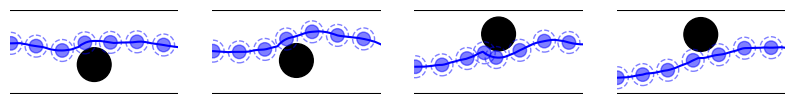

In [25]:
import time


checkpoint_callback = CheckpointCallback(
  save_freq=10000,
  save_path=logs,
  name_prefix="checkpoints",
)

cb = CallbackList([checkpoint_callback, cb])


start = time.time()
model.learn(total_timesteps=5_000, progress_bar=False, tb_log_name="SAC", callback=cb, reset_num_timesteps=False);
print(f'Training took {time.time() - start: .0f} seconds')

In [26]:
model.num_timesteps

5000

In [41]:
model.logger.dump??

Signature: model.logger.dump(step: int = 0) -> None
Source:   
    def dump(self, step: int = 0) -> None:
        """
        Write all of the diagnostics from the current iteration
        """
        if self.level == DISABLED:
            return
        for _format in self.output_formats:
            if isinstance(_format, KVWriter):
                _format.write(self.name_to_value, self.name_to_excluded, step)

        self.name_to_value.clear()
        self.name_to_count.clear()
        self.name_to_excluded.clear()
File:      ~/Dev/venv/ros_jazzy/lib/python3.12/site-packages/stable_baselines3/common/logger.py
Type:      method

In [ ]:
# import torch as th

# th.Tensor(model.policy_kwargs['net_arch'])

It learns at good performing policy in about 50000 steps. It takes about 5x longer compared to Dagger but the policy is also better, especialy the worst case.

In [ ]:
# import torch

# x = env.observation_space.sample()
# x = np.expand_dims(x, axis=0)
# x = torch.from_numpy(x)
# writer.add_graph(model.policy.actor, x, use_strict_trace=True, verbose=True)

In [ ]:
# writer.flush()

In [ ]:
# !pip install onnx

In [ ]:
# class OnnxablePolicy(torch.nn.Module):
#     def __init__(self, actor: torch.nn.Module):
#         super().__init__()
#         self.actor = actor

#     def forward(self, observation: torch.Tensor) -> torch.Tensor:
#         # NOTE: You may have to postprocess (unnormalize) actions
#         # to the correct bounds (see commented code below)
#         return self.actor(observation, deterministic=True)

# onnxable_model = OnnxablePolicy(model.policy.actor)

# torch.onnx.export(
#     onnxable_model,
#     x,
#     "my_sac_actor.onnx",
#     opset_version=17,
#     input_names=["input"],
# )

In [ ]:
# writer.add_onnx_graph('my_sac_actor.onnx')
# writer.flush()

In [ ]:
# from stable_baselines3.common.logger import HParam

# hparam_dict = {
#     "algorithm1": "TEST",
#     "learning rate1": 0.1,
#     "size1": 1}
# metric_dict = {
#     "eval/reward/mean": 0.0,
#     "eval/reward/min": 0.0}
# model.logger.record(
#     "hparams",
#     HParam(hparam_dict, metric_dict),
#     exclude=("stdout", "log", "json", "csv"))

In [ ]:
# writer.flush()

In [ ]:
# exp = sim.Experiment()

In [ ]:
# exp.remove_all_runs()

In [ ]:
import pandas as pd

df = pd.read_csv(f'{logs}/progress.csv')
df.plot(y='rollout/ep_rew_mean', x='time/total_timesteps');

In [ ]:
plot_test_runs(policy=model.policy, seed=123, color='blue') 

In [ ]:
from stable_baselines3.common.evaluation import evaluate_policy

sac_rewards, steps = evaluate_policy(model.policy, test_venv, 1000, return_episode_rewards=True)
np.min(sac_rewards),  np.mean(sac_rewards), np.median(sac_rewards), np.max(sac_rewards)

In [ ]:
plt.hist(sac_rewards, bins=10, density=True);
plt.xlabel('reward')
plt.ylabel('probability');
plt.title("Policy trained with SAC");

In [ ]:
model.save(f"{logs}/model")

## Comparision with HL

In [ ]:
hl_rewards = evaluate_expert(env, runs=1000, seed=0)

In [ ]:
plt.hist(sac_rewards, bins=np.linspace(np.quantile(sac_rewards, 0.02), np.quantile(sac_rewards, 0.98), 10), density=True, label="SAC", alpha=0.5)
plt.hist(bc_rewards, bins=np.linspace(np.quantile(bc_rewards, 0.02), np.quantile(bc_rewards, 0.98), 30), density=True, label="BC", alpha=0.5)
plt.hist(dagger_rewards, bins=np.linspace(np.quantile(dagger_rewards, 0.02), np.quantile(dagger_rewards, 0.98), 10), density=True, label="DAgger", alpha=0.5)
plt.hist(hl_rewards, bins=np.linspace(np.quantile(hl_rewards, 0.02), np.quantile(hl_rewards, 0.98), 10), density=True, label="HL", alpha=0.5)
plt.xlabel('reward')
plt.ylabel('probability');
plt.xlim(-50, 0)
plt.legend();

In [ ]:
plot_comparison_test_runs(policies=((bc_trainer.policy, 'orange', 'BC'), 
                                    (dagger_trainer.policy, 'green', 'DAgger'), 
                                    (model.policy, 'blue', 'SAC'),
                                    (None, 'red', 'Expert')), seed=123, step=10, cols=4, rows=4)
plt.legend(bbox_to_anchor=(-.75, 0), ncols=4)

In [ ]:
f = model.logger.output_formats[0]

In [ ]:
fs = [f for f in model.logger.output_formats if isinstance(f, sb3.common.logger.TensorBoardOutputFormat)]

In [ ]:
f = fs[0]

In [ ]:
from torch.utils.tensorboard.writer import SummaryWriter

In [ ]:
import stable_baselines3 as sb3

In [ ]:
1

In [ ]:
2